In [1]:
# !pip install xgboost

In [98]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

SEED = 42

In [6]:
data = pd.read_csv('../Data/petrol_consumption.xls')
data.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [7]:
X = data.drop('Petrol_Consumption', axis=1).values
y = data.Petrol_Consumption.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

In [15]:
reg_tree = DecisionTreeRegressor(random_state=SEED)

# training the tree
reg_tree.fit(X_train, y_train)
tree_y_pred = reg_tree.predict(X_test)

print(f"RMSE for the Decision Tree regressor: {np.sqrt(mean_squared_error(y_test, tree_y_pred)): .3f}.")

RMSE for the Decision Tree regressor:  131.711.


In [16]:
# create an xgboost regressor with trees as weak learners
xg_reg = xgb.XGBRFRegressor(objective='reg:linear', n_estimators=10, seed=SEED)

# training the xgboost regressor 
xg_reg.fit(X_train, y_train)
xg_y_pred = xg_reg.predict(X_test)

print(f"RMSE for the XGBoost regressor with trees as weak learners: {np.sqrt(mean_squared_error(y_test, xg_y_pred)): .3f}.")

[12:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for the XGBoost regressor with trees as weak learners:  102.932.


In [17]:
# create an xgboost regressor with linear weak learners
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)
params = {'booster': 'gblinear', 'objective': 'reg:linear'}

# training the xgboost regressor 
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)
xg_lin_y_pred = xg_reg.predict(DM_test)

print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xg_lin_y_pred)): .3f}.")

[12:44:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  81.771.


It looks like **linear base learners** performed better!
Let's evaluate the quality of the model using CV.

In [19]:
matrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=matrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=SEED)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

[12:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       422.733505        6.490174      422.022789      27.689916
1       308.452126        5.156648      314.249763      28.152355
2       228.738617        4.461358      236.023766      25.490554
3       171.975532        3.

In [21]:
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=matrix, params=params, nfold=4, num_boost_round=5, metrics='mae', as_pandas=True, seed=SEED)

# Extract and print final boosting round metric using mae
print((cv_results["test-mae-mean"]).tail(1))

[12:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
4    116.690403
Name: test-mae-mean, dtype: float64


Let's try to apply the regularization for our example.

In [26]:
l1_params = [1, 10, 100]
rmses_l1 = []

for reg in l1_params:
    params['alpha'] = reg
    cv_results = xgb.cv(
        dtrain=matrix, 
        params=params, 
        nfold=4, 
        num_boost_round=10, 
        metrics='rmse', 
        as_pandas=True, 
        seed=SEED
    )
    rmses_l1.append(cv_results['test-rmse-mean'].tail(1).values[0])
    
print('Best rmse as a function of l1:')
print(pd.DataFrame(list(zip(l1_params, rmses_l1)), columns=['l1', 'rmse']))

[13:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

In [27]:
l2_params = [1, 10, 100]
rmses_l2 = []

for reg in l2_params:
    params['lambda'] = reg
    cv_results = xgb.cv(
        dtrain=matrix, 
        params=params, 
        nfold=4, 
        num_boost_round=10, 
        metrics='rmse', 
        as_pandas=True, 
        seed=SEED
    )
    rmses_l2.append(cv_results['test-rmse-mean'].tail(1).values[0])
    
print('Best rmse as a function of l2:')
print(pd.DataFrame(list(zip(l2_params, rmses_l2)), columns=['l2', 'rmse']))

[13:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

In [33]:
# plot the trees
# pip install graphviz

# Plot the first tree
# xgb.plot_tree(xg_reg, num_trees=0)
# plt.show()

# Plot the fifth tree
# xgb.plot_tree(xg_reg, num_trees=4)
# plt.show()

# Plot the last tree sideways
# xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
# plt.show()

### Visualizing feature importances

[13:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


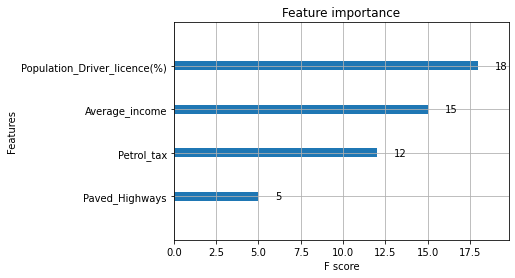

In [40]:
X = data.drop('Petrol_Consumption', axis=1)
y = data.Petrol_Consumption
matrix = xgb.DMatrix(data=X, label=y)

params = {'objective': 'reg:linear', 'max_depth': 4}

# training the xgboost regressor 
xg_reg = xgb.train(params=params, dtrain=matrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

### Model tuning

In [47]:
untuned_param = {'objective': 'reg:linear'}
untuned_cv_results = xgb.cv(
    dtrain=matrix, 
    params=untuned_param, 
    nfold=4, 
    metrics='rmse', 
    as_pandas=True, 
    seed=SEED
)
print(f"Untuned rmse: {untuned_cv_results['test-rmse-mean'].tail(1).values[0]: .3f}.")

[13:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Untuned rmse:  76.751.


In [68]:
tuned_param = {'objective': 'reg:linear', 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5}
tuned_cv_results = xgb.cv(
    dtrain=matrix, 
    params=tuned_param, 
    nfold=4, 
    num_boost_round=200,
    metrics='rmse', 
    as_pandas=True, 
    seed=SEED
)
print(f"Tuned rmse: {tuned_cv_results['test-rmse-mean'].tail(1).values[0]: .3f}.")

[13:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Tuned rmse:  87.437.


Badly tuned model can give even worse result than the untuned one.

In [55]:
# Create list of number of boosting rounds
num_rounds = [5, 50, 100, 150]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(params=params, dtrain=matrix, nfold=3, 
                        num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=SEED)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

We see that it makes no sense to increate the num_boosting_rounds parameter after some point. To prevent it we can use the early_stopping_rounds argument in the xgb.cv function.

In [56]:
matrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = cv_results = xgb.cv(
    dtrain=matrix, 
    params=params, 
    nfold=3, 
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics='rmse', 
    as_pandas=True, 
    seed=SEED
)

# Print cv_results
print(cv_results)

[13:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        423.289856        5.172641      423.144134      16.388362
1        309.468333        4.239822      310.112193      15.670285
2        229.739370        3.815162      229.964508      13.138498
3        173.342880        3.930569      174.787852      13.375398
4        133.207937        3.993573      136.389290      13.978813
5        103.784498        3.919044      109.074956      14.290427


### Tune the learning rate

In [59]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:linear", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1, 0.2, 0.3]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(
        dtrain=matrix, 
        params=params, 
        nfold=3, 
        early_stopping_rounds=5,
        num_boost_round=10,
        metrics='rmse', 
        as_pandas=True, 
        seed=SEED
    )
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

In [77]:
tuned_param = {'objective': 'reg:linear', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2}
tuned_cv_results = xgb.cv(
    dtrain=matrix, 
    params=tuned_param, 
    nfold=4, 
    num_boost_round=100,
    metrics='rmse', 
    as_pandas=True, 
    seed=SEED
)
print('\n')
print("Untuned rmse: 76.751.")
print("Wrongly tuned rmse: 87.437.")
print(f"Correctly tuned rmse: {tuned_cv_results['test-rmse-mean'].tail(1).values[0]: .3f}.")

[13:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


Untuned rmse: 76.751.
Wrongly tuned rmse: 87.437.
Correctly tuned rmse:  70.113.


### Let's try a Random hyperparameter search

In [86]:
gbm_param_grid = {
    'learning_rate': np.arange(0.05, 1.05, 0.05),
    'subsample': np.arange(0.05, 1.05, 0.05),
    'colsample_bytree': np.arange(0.1, 1.1, 0.1),
    'max_depth': range(2, 12)
}
gbm = xgb.XGBRegressor(n_estimators=10)
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, scoring='neg_mean_squared_error',
                  cv=4, verbose=1)
randomized_mse.fit(X, y)

print(f'Best parameters found: {randomized_mse.best_params_}.')
print(f'Lowest RMSE found: {np.sqrt(abs(randomized_mse.best_score_))}.')

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found: {'subsample': 0.4, 'max_depth': 4, 'learning_rate': 0.55, 'colsample_bytree': 0.5}.
Lowest RMSE found: 87.27585173376536.


In [101]:
steps = [('st_scaler', StandardScaler()), ('rf_model', RandomForestRegressor())]

rf_pipeline = Pipeline(steps)

scores = cross_val_score(rf_pipeline, X, y, scoring='neg_mean_squared_error', cv=10)
final_avg_rmse = np.mean(np.sqrt(abs(scores)))
print(f"Final RMSE: {final_avg_rmse}")

Final RMSE: 65.12240120592931


In [102]:
steps = [('st_scaler', StandardScaler()), ('xgb_model', xgb.XGBRegressor())]

xgb_pipeline = Pipeline(steps)

xgb_scores = cross_val_score(xgb_pipeline, X, y, scoring='neg_mean_squared_error', cv=10)
xgb_final_avg_rmse = np.mean(np.sqrt(abs(xgb_scores)))
print(f"Final xgb RMSE: {xgb_final_avg_rmse}")

Final xgb RMSE: 71.9338901768288


## Final example

In [111]:
!pip install sklearn_pandas==1.8.0

  Attempting uninstall: sklearn-pandas
    Found existing installation: sklearn-pandas 2.2.0
    Uninstalling sklearn-pandas-2.2.0:
      Successfully uninstalled sklearn-pandas-2.2.0


In [114]:
# Import necessary modules
from sklearn_pandas import DataFrameMapper
# from sklearn_pandas import CategoricalImputer

> [The chronic kidney disease dataset](https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease) contains both categorical and numeric features, but contains lots of missing values. The goal here is to predict who has chronic kidney disease given various blood indicators as features.

In [115]:
kidney_df = pd.read_csv('../Data/kidney_disease.csv')
kidney_df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [116]:
X = kidney_df.drop('classification', axis=1)
y = kidney_df.classification

In [120]:
# Import necessary modules
from sklearn_pandas import DataFrameMapper
# from sklearn_pandas import CategoricalImputer

# Check number of nulls in each feature column
nulls_per_column = X.isnull().sum()
print(nulls_per_column)

# Create a boolean mask for categorical columns
categorical_feature_mask = X.dtypes == object

# Get list of categorical column names
categorical_columns = X.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer
numeric_imputation_mapper = DataFrameMapper(
                                            [([numeric_feature],Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
                                            input_df=True,
                                            df_out=True
                                           )

# Apply categorical imputer
categorical_imputation_mapper = DataFrameMapper(
                                                [(category_feature, CategoricalImputer()) for category_feature in categorical_columns],
                                                input_df=True,
                                                df_out=True
                                               )

ImportError: cannot import name 'Imputer' from 'sklearn_pandas' (c:\users\voytik\anaconda3\envs\ds\lib\site-packages\sklearn_pandas\__init__.py)

In [ ]:
# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
                                          ("num_mapper", numeric_imputation_mapper),
                                          ("cat_mapper", categorical_imputation_mapper)
                                         ])

In [ ]:
# Create full pipeline
pipeline = Pipeline([
                     ("featureunion", numeric_categorical_union),
                     ("dictifier", Dictifier()),
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBClassifier(max_depth=3))
                    ])

# Perform cross-validation
cross_val_scores = cross_val_score(pipeline, kidney_data, y, scoring='roc_auc', cv=3)

# Print avg. AUC
print("3-fold AUC: ", np.mean(cross_val_scores))

In [ ]:
# Create the parameter grid
gbm_param_grid = {
    'clf__learning_rate': np.arange(0.05, 1, 0.05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=pipeline, param_distributions=gbm_param_grid, n_iter=2, scoring='roc_auc', verbose=1, cv=2)

# Fit the estimator
randomized_roc_auc.fit(X, y)

# Compute metrics
print(randomized_roc_auc.best_score_)
print(randomized_roc_auc.best_estimator_)

Hyperparameters optimization:
- try Bayesian Optimization